In [1]:
import random
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pytorch_lightning as pl

In [ ]:
class GraphClassificationGCN(pl.LightningModule):
    
    def __init__(self, **model_kwargs):
        super().__init__()
        # Saving hyperparameters
        self.save_hyperparameters()

        self.model = GCN4(
            feature_dim_size=self.hparams.feature_dim_size,
            dropout=getattr(self.hparams, "dropout", 0.3),
        )
        self.loss_module = nn.CrossEntropyLoss()

    def forward(self, data, mode="train"):
        x, edge_index, batch_idx = data.x, data.edge_index, data.batch
        logits = self.model(x, edge_index, batch_idx)

        targets = data.y.long().view(-1)
        loss = self.loss_module(logits, targets)
        preds = logits.argmax(dim=-1)
        acc = (preds == targets).float().mean()
        return loss, acc

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=0.001, weight_decay=0.0) # High lr because of small dataset and small model
        return optimizer

    def training_step(self, batch, batch_idx):
        loss, acc = self.forward(batch, mode="train")
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=False)
        self.log('train_acc', acc, on_step=False, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        loss, acc = self.forward(batch, mode="val")
        self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=False)
        self.log('val_acc', acc, on_step=False, on_epoch=True, prog_bar=True)

    def test_step(self, batch, batch_idx):
        loss, acc = self.forward(batch, mode="test")
        self.log('test_loss', loss, on_step=False, on_epoch=True)
        self.log('test_acc', acc, on_step=False, on_epoch=True)

In [2]:
SEED = 55
EPOCHS = 60
LR = 0.001
DROPOUT = 0.3
VAL_SPLIT = 0.2

random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
pl.seed_everything(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

print(torch.cuda.get_arch_list())
print(torch.cuda.is_available())
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
#DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

Seed set to 55


['sm_50', 'sm_60', 'sm_70', 'sm_75', 'sm_80', 'sm_86', 'sm_90']
True
Using device: cuda


# Load dataset with DataLoader

In [3]:
from pathlib import Path

BASE_DIR = Path.cwd().parent
DATASET_FILE = BASE_DIR / "GCN" / "training_ready_dataset.pt"

if DATASET_FILE.exists():
    dataset = torch.load(DATASET_FILE, weights_only=False)
    print(f"Loaded dataset with {len(dataset)} graphs from {DATASET_FILE}")
else:
    dataset = []
    print(f"Dataset file not found at {DATASET_FILE}. Add data or build dataset first.")

# Basic sanity check
if len(dataset) > 0:
    assert hasattr(dataset[0], 'x') and hasattr(dataset[0], 'edge_index') and hasattr(dataset[0], 'y'), \
        "Each Data must have x, edge_index, and y"
    print(f"First object: {dataset[0]}")
    print(f"Number of classes: {dataset[0].y.max().item() + 1}")
    print(f"Number of attributes: {dataset[0].x.size(-1)}")

Loaded dataset with 300 graphs from /home/mrestebato/Documents/Tec/7mo-semestre/ai/reto/3d-part-localization/GCN/training_ready_dataset.pt
First object: Data(edge_index=[2, 1296], num_nodes=352, x=[352, 10], y=[1])
Number of classes: 2
Number of attributes: 10


In [4]:
import torch_geometric.loader as geom_loader

if len(dataset) > 0:
    labels = [int(d.y.item()) for d in dataset]
    train_idx, val_idx = train_test_split(list(range(len(dataset))), test_size=VAL_SPLIT, random_state=SEED, stratify=labels if len(set(labels)) > 1 else None)
    train_dataset = [dataset[i] for i in train_idx]
    val_dataset = [dataset[i] for i in val_idx]

    print(f"Train graphs: {len(train_dataset)} | Val graphs: {len(val_dataset)}")
else:
    train_dataset = []
    val_dataset = []

graph_train_loader = geom_loader.DataLoader(train_dataset, batch_size=32, shuffle=True)
graph_val_loader = geom_loader.DataLoader(val_dataset, batch_size=32, shuffle=False)

batch = next(iter(graph_val_loader))
print("Batch:", batch)
print("Labels:", batch.y[:10])
print("Batch indices:", batch.batch)

Train graphs: 240 | Val graphs: 60
Batch: DataBatch(edge_index=[2, 48024], num_nodes=13146, x=[13146, 10], y=[32], batch=[13146], ptr=[33])
Labels: tensor([1, 1, 0, 1, 0, 1, 1, 1, 1, 1])
Batch indices: tensor([ 0,  0,  0,  ..., 31, 31, 31])


In [12]:
import os
from pytorch_lightning.callbacks import ModelCheckpoint
from GCN import GraphClassificationGCN
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
CHECKPOINT_PATH = BASE_DIR / "GCN"

# Callback to store epoch metrics
class MetricsCallback(pl.Callback):
    def __init__(self):
        super().__init__()
        self.history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

    def on_validation_epoch_end(self, trainer, pl_module):
        m = trainer.callback_metrics  # contains *_epoch from our logs
        def get(name, default=np.nan):
            return float(m[name].item()) if name in m and m[name] is not None else default
        self.history["train_loss"].append(get("train_loss_epoch"))
        self.history["train_acc"].append(get("train_acc"))
        self.history["val_loss"].append(get("val_loss"))
        self.history["val_acc"].append(get("val_acc"))


# Use the callback during training
def train_graph_classifier(model_name):

    root_dir = os.path.join(CHECKPOINT_PATH, "GraphLevel" + model_name)
    os.makedirs(root_dir, exist_ok=True)

    metrics_cb = MetricsCallback()
    trainer = pl.Trainer(
        default_root_dir=root_dir,
        callbacks=[ModelCheckpoint(save_weights_only=True, mode="max", monitor="val_acc"), metrics_cb],
        accelerator=DEVICE,
        devices=1,
        max_epochs=500,
        enable_progress_bar=True,
    )

    pretrained_filename = os.path.join(CHECKPOINT_PATH, f"GraphLevel{model_name}.ckpt")
    if os.path.isfile(pretrained_filename):
        print("Found pretrained model, loading...")
        model = GraphClassificationGCN.load_from_checkpoint(pretrained_filename)
    else:
        model = GraphClassificationGCN(feature_dim_size=train_dataset[0].x.size(-1), dropout=DROPOUT)
        trainer.fit(model, graph_train_loader, graph_val_loader)
        model = GraphClassificationGCN.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)

    # Plot accuracy and loss (per epoch)
    hist = metrics_cb.history
    epochs = np.arange(1, len(hist["train_acc"]) + 1)

    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    axs[0].plot(epochs, hist["train_acc"], label="train")
    axs[0].plot(epochs, hist["val_acc"], label="val")
    axs[0].set_title("Accuracy")
    axs[0].set_xlabel("Epoch")
    axs[0].set_ylabel("Acc")
    axs[0].legend()

    axs[1].plot(epochs, hist["train_loss"], label="train")
    axs[1].plot(epochs, hist["val_loss"], label="val")
    axs[1].set_title("Loss")
    axs[1].set_xlabel("Epoch")
    axs[1].set_ylabel("Loss")
    axs[1].legend()
    plt.tight_layout()
    plt.show()

    # Confusion matrix on validation set (best checkpoint)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device).eval()

    ys, y_preds = [], []
    with torch.no_grad():
        for batch in graph_val_loader:
            batch = batch.to(device)
            logits = model.model(features=batch.x, adj=batch.edge_index, batch=batch.batch)  # [G, 2]
            preds = logits.argmax(dim=1).cpu().numpy()
            ys.append(batch.y.view(-1).cpu().numpy())
            y_preds.append(preds)
    ys = np.concatenate(ys)
    y_preds = np.concatenate(y_preds)

    labels = [0, 1]
    disp = ConfusionMatrixDisplay(confusion_matrix(ys, y_preds, labels=labels),
                                  display_labels=["other", "heatstake"])
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    disp.plot(ax=ax, cmap="Blues", colorbar=False)
    ax.set_title("Validation Confusion Matrix")
    plt.tight_layout()
    plt.show()

    try:
        print("\nValidation Classification Report:")
        print(classification_report(ys, y_preds, target_names=["other", "heatstake"]))
    except Exception as e:
        print("Could not generate classification report:", e)

    # Also return metrics
    train_result = trainer.test(model, graph_train_loader, verbose=False)
    test_result = trainer.test(model, graph_val_loader, verbose=False)
    result = {"test": test_result[0]["test_acc"], "train": train_result[0]["test_acc"]}
    return model, result

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | Mode 
---------------------------------------------------------
0 | model       | GCN4             | 402    | train
1 | loss_module | CrossEntropyLoss | 0      | train
---------------------------------------------------------
402       Trainable params
0         Non-trainable params
402       Total params
0.002     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/home/mrestebato/.conda/envs/heatstakes/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


/home/mrestebato/.conda/envs/heatstakes/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/home/mrestebato/.conda/envs/heatstakes/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (8) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 499: 100%|██████████| 8/8 [00:00<00:00, 55.07it/s, v_num=0, val_acc=0.500, train_acc=0.496] 

`Trainer.fit` stopped: `max_epochs=500` reached.


Epoch 499: 100%|██████████| 8/8 [00:00<00:00, 54.36it/s, v_num=0, val_acc=0.500, train_acc=0.496]


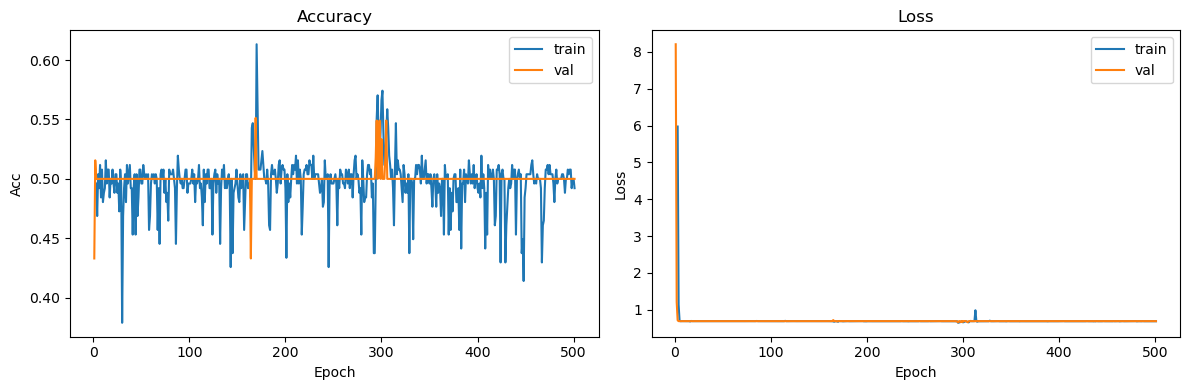

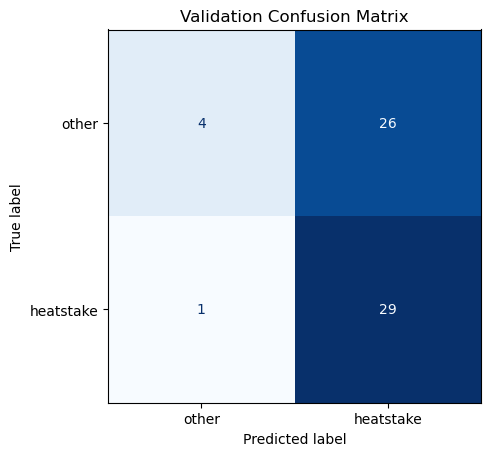

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/mrestebato/.conda/envs/heatstakes/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:484: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
/home/mrestebato/.conda/envs/heatstakes/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:433: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.



Validation Classification Report:
              precision    recall  f1-score   support

       other       0.80      0.13      0.23        30
   heatstake       0.53      0.97      0.68        30

    accuracy                           0.55        60
   macro avg       0.66      0.55      0.46        60
weighted avg       0.66      0.55      0.46        60

Testing DataLoader 0: 100%|██████████| 8/8 [00:00<00:00, 88.45it/s] 

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Testing DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 109.71it/s]
Train performance: 60.16%
Test performance:  55.13%


In [13]:
model, result = train_graph_classifier(model_name="2")

print(f"Train performance: {100.0*result['train']:4.2f}%")
print(f"Test performance:  {100.0*result['test']:4.2f}%")

In [39]:
torch.save(model.state_dict(), BASE_DIR / "GCN" / "heatstake_classifier6.pth")